# Install required libraries

In [2]:
import os
os.getcwd()

'c:\\Users\\uday\\OneDrive\\Desktop\\emr_git\\EMR'

# Import the libraries

In [3]:
import soundfile # to read audio file
import numpy as np

import librosa
import glob
import os
import pickle # to save model after training
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
from sklearn.metrics import accuracy_score # to measure how good we are
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Input, Flatten, Dropout, Activation, Dense
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, LSTM
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


# Function to extract features from the audio dataset

In [4]:
def extract_feature(file_name, print_flag=False, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if X.ndim >= 2:
            X = np.mean(X, 1)
        sample_rate = sound_file.samplerate
        result = np.array([])
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            if print_flag:
                print(f"MFCC shape: {mfccs.shape}")
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))
    return result

Filter the required emotions - We use only 5 emotions for training

In [5]:
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions ( feel free to tune this on your need )
AVAILABLE_EMOTIONS = {
    "neutral",
    "happy",
    "sad",
    "angry",

}

In [6]:
def load_data(test_size=0.2, print_flag=True):
    X, y = [], []
    for file in glob.glob("C://Users//uday//OneDrive//Desktop//EMR//EMR//Data//Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=False, mel=False, contrast=False, tonnetz=False, print_flag=print_flag)
        # add to data
        X.append(features)
        y.append(emotion)
        print_flag = False  # Set print_flag to False after the first iteration
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, train_size=0.7, random_state=7)

# Function to load data and split the training and test data

In [7]:
X_train, X_test, y_train1, y_test1 = load_data(test_size=0.30)

MFCC shape: (40,)


# Decision Tree Classifier
To make a first attempt in accomplishing this classification task we chose a decision tree just to get familiar with initial predictions before training with preferred CNN

In [8]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train1)

DecisionTreeClassifier()

In [9]:
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test1,predictions))
print(X_test.shape)

              precision    recall  f1-score   support

       angry       0.76      0.67      0.71        57
       happy       0.78      0.78      0.78        55
     neutral       0.69      0.61      0.65        33
         sad       0.60      0.73      0.66        49

    accuracy                           0.71       194
   macro avg       0.71      0.70      0.70       194
weighted avg       0.71      0.71      0.71       194

(194, 40)


# Tailor the input dimension to fit the model

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted
# using extract_features() function
print("[+] Number of features:", X_train.shape[1])

lb = LabelEncoder()

y_train=np.array(y_train1)
y_test=np.array(y_test1)

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

print(x_traincnn.shape)
print(x_testcnn.shape)
print(y_train.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(np.argmax(y_train, axis=1)), 
                                     y=np.argmax(y_train, axis=1))
# Convert the computed class weights to a dictionary format
class_weights = dict(enumerate(class_weights))

# Print class weights to understand the distribution
print("Class weights:", class_weights)


[+] Number of training samples: 450
[+] Number of testing samples: 194
[+] Number of features: 40
(450, 40, 1)
(194, 40, 1)
(450, 4)
(194, 4)
Class weights: {0: 0.8858267716535433, 1: 0.872093023255814, 2: 1.9067796610169492, 3: 0.8333333333333334}


# Train the model

Model 1

In [59]:
model = Sequential()

model.add(Conv1D(32, 3, padding='same', activation='relu', input_shape=(40, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Conv1D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnnhistory = model.fit(x_traincnn, np.array(y_train), batch_size=277, epochs=860, validation_data=(x_testcnn, np.array(y_test)), 
                       class_weight=class_weights)
print("Accuracy: {:.2f}%".format(cnnhistory.history['accuracy'][-1] * 100))
print("Validation Accuracy: {:.2f}%".format(cnnhistory.history['val_accuracy'][-1] * 100))


Epoch 1/860


c:\Users\uday\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.2824 - loss: 10.9810 - val_accuracy: 0.2680 - val_loss: 2.1492
Epoch 2/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2762 - loss: 5.8746 - val_accuracy: 0.1701 - val_loss: 5.1689
Epoch 3/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1641 - loss: 6.2967 - val_accuracy: 0.1701 - val_loss: 4.3703
Epoch 4/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1812 - loss: 4.9000 - val_accuracy: 0.2526 - val_loss: 3.1291
Epoch 5/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2460 - loss: 4.2030 - val_accuracy: 0.2526 - val_loss: 3.5181
Epoch 6/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2981 - loss: 3.8724 - val_accuracy: 0.2526 - val_loss: 2.6014
Epoch 7/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2766 - loss: 3.9828 - val_accuracy: 0.3814 - val_loss: 1.9477
Epoch 8/860
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3005 - loss: 3.3021 - val_accuracy: 0.2629 - val_loss: 1.4796
Ep

Train new one

In [60]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,926 (261.43 KB)

 Trainable params: 22,308 (87.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 44,618 (174.29 KB)

In [61]:
from keras.utils import to_categorical
predictions = model.predict(x_testcnn)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes_onehot = to_categorical(predicted_classes, num_classes=4)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [62]:
y_test
new_Ytest = y_test.astype(int)
new_Ytest

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0,

In [63]:
print(type(new_Ytest))
print(type(predicted_classes_onehot))
print(predicted_classes_onehot.shape)
print(new_Ytest.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(194, 4)
(194, 4)


In [64]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predicted_classes_onehot)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        57
           1       0.96      0.98      0.97        55
           2       0.97      0.97      0.97        33
           3       0.98      0.96      0.97        49

   micro avg       0.97      0.97      0.97       194
   macro avg       0.97      0.97      0.97       194
weighted avg       0.97      0.97      0.97       194
 samples avg       0.97      0.97      0.97       194



In [65]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest.argmax(axis=1), predicted_classes_onehot.argmax(axis=1))
print(matrix)
# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 
# we ignored 5 = fearful, 6 = disgust, 7 = surprised


[[55  2  0  0]
 [ 1 54  0  0]
 [ 0  0 32  1]
 [ 1  0  1 47]]


# Save the model

In [79]:
model_name = 'Emotion_Voice_Detection_Model1.h5'
model_path = os.path.join('C://Users//uday//OneDrive//Desktop//emr_git//EMR//model', model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at C://Users//uday//OneDrive//Desktop//emr_git//EMR//model\Emotion_Voice_Detection_Model1.h5 


Save the model to a json file

In [80]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

In [81]:
new_model=keras.models.load_model('C://Users//uday//OneDrive//Desktop//emr_git//EMR//model//Emotion_Voice_Detection_Model1.h5')
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,310 (87.15 KB)

 Trainable params: 22,308 (87.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [82]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9646 - loss: 0.1407  
Restored model, accuracy: 96.91%


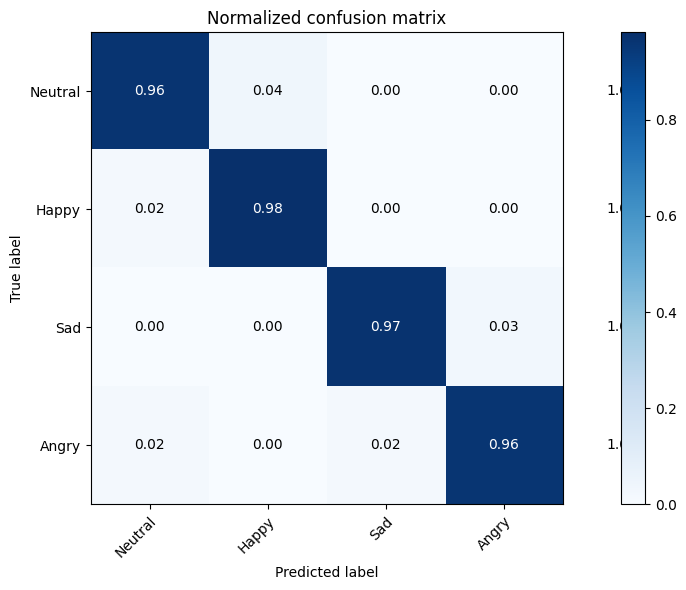

----accuracy score 96.90721649484536 ----


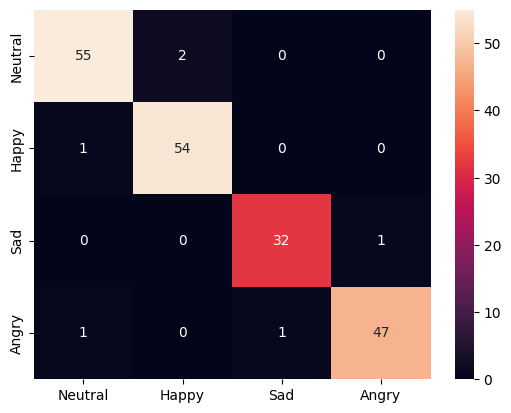

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(new_Ytest, predicted_classes_onehot, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(new_Ytest, predicted_classes_onehot, labels=np.arange(len(classes)))
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm)  # Replace nan with 0 and inf with large finite numbers

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Display the values in the matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    # Add normalized sample values under each true label
    for i in range(cm.shape[0]):
        normalized_value = np.sum(cm[i, :])
        ax.text(cm.shape[1], i, '{:.2f}'.format(normalized_value), ha="center", va="center", color="black")

    fig.tight_layout()
    return ax

# Assuming new_Ytest and predicted_classes_onehot are defined elsewhere in your code
# And they are already in one-hot encoded format

emotion_labels = ['Neutral',  'Happy', 'Sad', 'Angry']

# Convert new_Ytest and predicted_classes_onehot to class indices
new_Ytest_indices = new_Ytest.argmax(axis=1)
predicted_classes_indices = predicted_classes_onehot.argmax(axis=1)

plot_confusion_matrix(new_Ytest_indices, predicted_classes_indices, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

acc = float(accuracy_score(new_Ytest_indices, predicted_classes_indices)) * 100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(new_Ytest_indices, predicted_classes_indices)
df_cm = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)
sn.heatmap(df_cm, annot=True, fmt='d')

plt.show()


## Prediction

In [84]:
import os

file_path = 'C://Users//uday//OneDrive//Desktop//EMR//EMR//Data//Actor_08/03-02-06-02-02-01-08.wav'

if os.path.exists(file_path):
    print("File exists.")
else:
    print("File does not exist or path is incorrect.")


File exists.


In [85]:

import librosa
data, sampling_rate = librosa.load("C://Users//uday//OneDrive//Desktop//EMR//EMR//Data//Actor_08/03-02-02-02-01-02-08.wav")

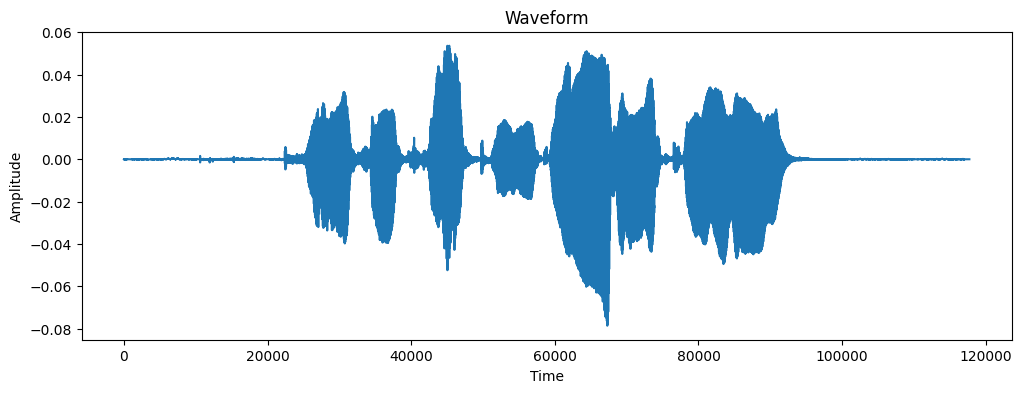

In [86]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(12, 4))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

Process the model for prediction

In [87]:

import pandas as pd
feature_test=extract_feature('C://Users//uday//OneDrive//Desktop//EMR//EMR//Data/Actor_08/03-02-03-01-02-01-08.wav', mfcc=True, chroma=False, mel=False)
livedf2 = feature_test
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T

In [88]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-598.295776,51.863773,-16.619463,3.937807,-2.683055,4.682492,-21.50654,2.437082,-5.834357,-10.455375,...,-1.537167,2.499536,4.737503,3.403556,0.353728,-2.528045,-2.00934,3.880819,5.769512,4.155193


In [89]:
input_test= np.expand_dims(livedf2, axis=2)

In [90]:
input_test.shape

(1, 40, 1)

Load model and run prediction

In [92]:
from keras.models import model_from_json
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C://Users//uday//OneDrive//Desktop//emr_git//EMR//model//Emotion_Voice_Detection_Model1.h5")
print("Loaded model from disk")

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#score = loaded_model.evaluate(, y_test, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


preds = loaded_model.predict(input_test,
                         batch_size=277,
                         verbose=1)

Loaded model from disk
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


c:\Users\uday\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [77]:
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

preddf = pd.DataFrame({'predictedvalues': predictions})

In [78]:
preddf


,predictedvalues
0,happy


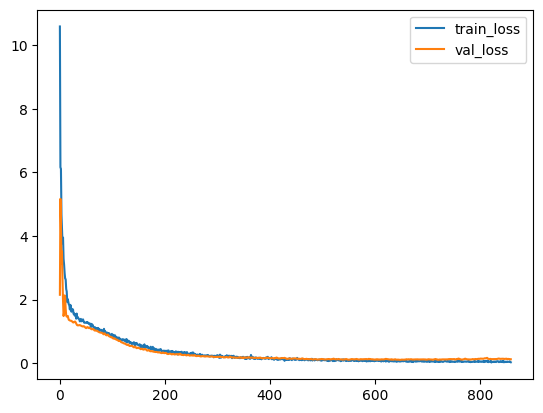

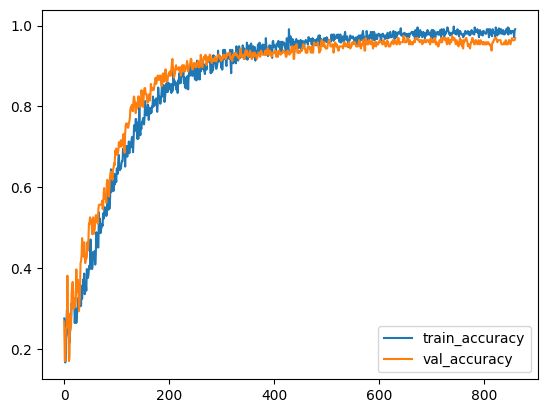

In [93]:
import matplotlib.pyplot as plt

plt.plot(cnnhistory.history['loss'], label='train_loss')
plt.plot(cnnhistory.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(cnnhistory.history['accuracy'], label='train_accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()